# Sberbank Competition

With Mercedes competition this is my first non training Kaggle competition (I joined both of them several days before deadline, so I didn't have enough time to work profoundly). 

Here is a price prediction task for flats in Moscow region. There is a similar training competition, but here were have more data, more features and we can experiment with adding macroeconomic data to improve our model. Also several features could be more useful for those who live in Moscow, and who know better its districts. 

In [2]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Imputer
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, learning_curve
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
#importing dataframes
df_train = pd.read_csv('train.csv', header = 0, index_col = 0)
df_test = pd.read_csv('test.csv', header = 0, index_col = 0)
df_macro = pd.read_csv('macro2.csv', header = 0, sep = ';')
y_train = df_train['price_doc'].values

print(df_train.shape, df_test.shape, df_macro.shape)

(30471, 291) (7662, 290) (2484, 100)


There are several features, which are numerical in data set, but in fact we have to use them as categorical, because ID of metro or railway station are surely non numerical.

In [4]:
# transforming dataframes and adding macro data
num_cat_var = ['ID_metro', 'ID_railroad_station_walk', 'ID_railroad_station_avto',
'ID_big_road1', 'ID_big_road2', 'ID_railroad_terminal', 'ID_bus_terminal']

df_train = df_train.join(df_macro.set_index('timestamp'), on = 'timestamp').drop(['timestamp', 
                         'provision_retail_space_modern_sqm', 'price_doc'], axis = 1)
df_test = df_test.join(df_macro.set_index('timestamp'), on = 'timestamp').drop(['timestamp',
                         'provision_retail_space_modern_sqm'], axis = 1)

df_train[num_cat_var] = df_train[num_cat_var].astype('object')
df_test[num_cat_var] = df_test[num_cat_var].astype('object')

df_train_num = df_train.select_dtypes(exclude = ['object'])
df_train_cat = df_train.select_dtypes(include = ['object'])

df_test_num = df_test.select_dtypes(exclude = ['object'])
df_test_cat = df_test.select_dtypes(include = ['object'])
print(df_train_num.shape, df_train_cat.shape, df_test_num.shape, df_test_cat.shape)

(30471, 365) (30471, 22) (7662, 365) (7662, 22)


There are also 6 categorical features, that have many categories (even more than 100), so using dummy variables for them is not the best choice. We will use here frequency of every category.

In [5]:
#categorical features
many_cat = ['sub_area', 'ID_metro', 'ID_railroad_station_walk', 'ID_railroad_station_avto', 
            'ID_big_road1', 'ID_big_road2']

df_train_mc = df_train_cat[many_cat]
df_train_mc.fillna('Unknown', inplace = True)
df_train_cat = df_train_cat.drop(many_cat, axis = 1)

df_test_mc = df_test_cat[many_cat]
df_test_mc.fillna('Unknown', inplace = True)
df_test_cat = df_test_cat.drop(many_cat, axis = 1)
df_test_cat = df_test_cat.apply(lambda x: x.fillna(x.value_counts().index[0]))

for feature in df_train_mc.columns:
    df_train_mc[feature] = df_train_mc[feature].map(df_train_mc.groupby(feature).size()) / len(df_train_mc)
    df_test_mc[feature] = df_test_mc[feature].map(df_test_mc.groupby(feature).size()) / len(df_test_mc)

df_all = pd.concat([df_train_cat, df_test_cat])
df_all = pd.get_dummies(df_all)
df_train_dummies = df_all.iloc[:len(df_train_cat),:]
df_test_dummies = df_all.iloc[len(df_train_cat):,:]

print(df_train_mc.shape, df_test_mc.shape, df_train_dummies.shape, df_test_dummies.shape)

(30471, 6) (7662, 6) (30471, 53) (7662, 53)


In [6]:
#numerical features
df_train_num = pd.concat([df_train_num, df_train_mc], axis = 1)
df_test_num = pd.concat([df_test_num, df_test_mc], axis = 1)

Here we all features, that have correlation with price more than 0.2 in absolute value. We see also, that only two features have correlation more than 0.3

In [7]:
#correlations
df_train_num['price_doc'] = y_train
correlations = abs(df_train_num.corrwith(df_train_num.iloc[:,-1])).sort_values(ascending = False)
correlations[correlations >= 0.2]

price_doc                     1.000000
num_room                      0.476337
full_sq                       0.341840
sport_count_5000              0.294864
sport_count_3000              0.290651
trc_count_5000                0.289371
zd_vokzaly_avto_km            0.284069
sadovoe_km                    0.283622
kremlin_km                    0.279249
bulvar_ring_km                0.279158
sport_count_2000              0.278056
ttk_km                        0.272620
office_sqm_5000               0.269977
trc_sqm_5000                  0.268072
sport_count_1500              0.258376
nuclear_reactor_km            0.257946
ID_metro                      0.254509
sport_objects_raion           0.252794
trc_count_3000                0.242068
cafe_count_5000_price_1000    0.240464
stadium_km                    0.236924
cafe_count_5000_price_1500    0.232612
cafe_count_5000               0.231546
cafe_count_5000_na_price      0.230055
cafe_count_5000_price_500     0.226952
office_sqm_3000          

Pairplots for ten most correlated features. We see, that distribution of all of them is not normal, moreover there are highly correlated features, and we have to take it into account.

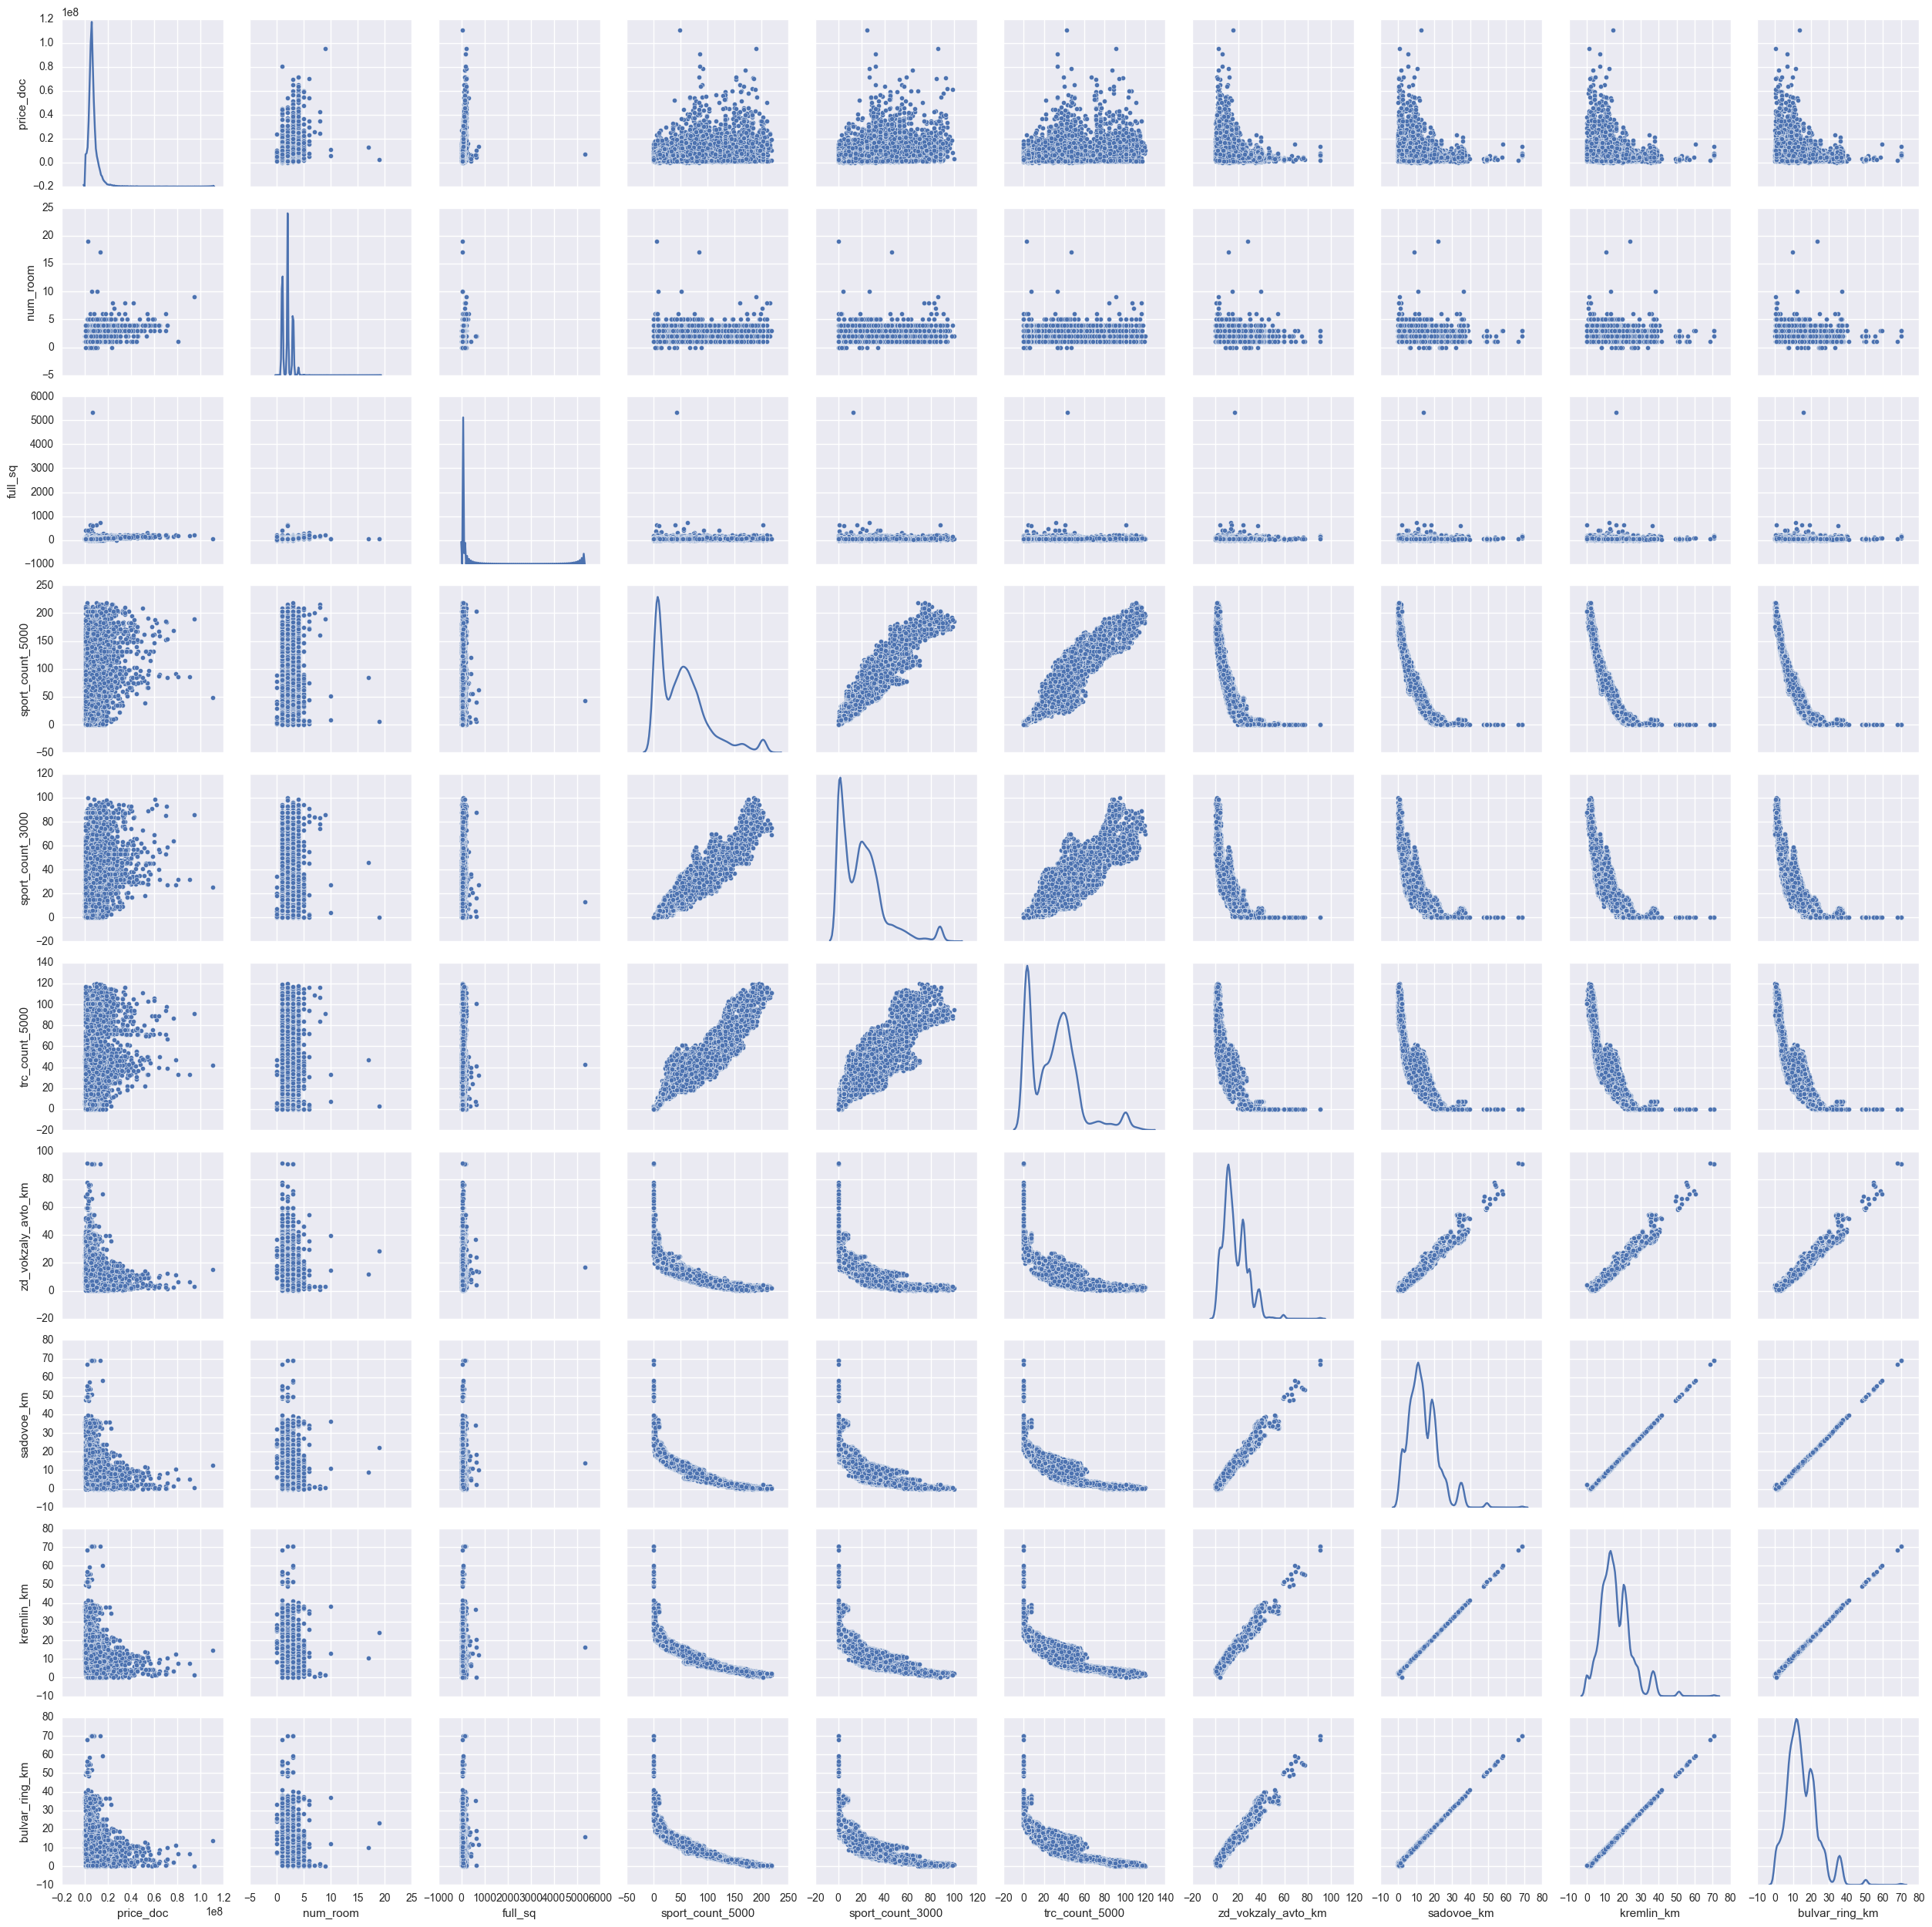

In [52]:
indices = correlations.index[:10]
seaborn.pairplot(df_train_num[indices], diag_kind = 'kde')

In [8]:
#train test sets
df_train_num.drop('price_doc', axis = 1, inplace = True)
X_train = np.concatenate((df_train_num.values, df_train_dummies), axis = 1)
X_test = np.concatenate((df_test_num.values, df_test_dummies), axis = 1)
print(X_train.shape, X_test.shape)

(30471, 424) (7662, 424)


Here we create baseline models, we try to use Linear Regression, Random Forest, Gradient Boosting, kNN regression. We use default parameters for every model (only for Random Forest we increase number of trees), and we choose, what strategy for missing values is the best for every model

In [9]:
#creating baseline models
kf = KFold(n_splits = 4, shuffle = True, random_state = 147)

pipe_lr = Pipeline([('imputer', Imputer()), ('scaler', StandardScaler()), ('linreg', LinearRegression())])
pipe_gb = Pipeline([('imputer', Imputer()), ('gb_reg', GradientBoostingRegressor(random_state = 147))])
pipe_rf = Pipeline([('imputer', Imputer()), ('rf_reg', RandomForestRegressor(n_estimators = 100, random_state = 147))])
pipe_knn = Pipeline([('imputer', Imputer()), ('scaler', MinMaxScaler()), ('knn', KNeighborsRegressor())])

imp_grid = {'imputer__strategy': ['mean', 'median', 'most_frequent']}

We calculate $R^2$ for every baseline models and choose best strategy for missing values. As we see, Linear Regression perform very poor (but there are highly correlated features in dataset, maybe adding regularization will help? therefore we will try to improve linear model using Elastic Net). Random Forest and Gradient Bossting work well, but the second is slightly better, kNN is not very good choice, so we will drop this model.

In [66]:
# R2 for baseline models
gs_base_lr = GridSearchCV(pipe_lr, imp_grid, cv = kf, scoring = 'r2')
gs_base_lr.fit(X_train, y_train)
gs_base_gb = GridSearchCV(pipe_gb, imp_grid, cv = kf, scoring = 'r2')
gs_base_gb.fit(X_train, y_train)
gs_base_rf = GridSearchCV(pipe_rf, imp_grid, cv = kf, scoring = 'r2')
gs_base_rf.fit(X_train, y_train)
gs_base_knn = GridSearchCV(pipe_knn, imp_grid, cv = kf, scoring = 'r2')
gs_base_knn.fit(X_train, y_train)

print(gs_base_lr.best_score_, gs_base_lr.best_params_,
      gs_base_gb.best_score_, gs_base_gb.best_params_,
      gs_base_rf.best_score_, gs_base_rf.best_params_,
      gs_base_knn.best_score_, gs_base_knn.best_params_,)

-0.778281553955 {'imputer__strategy': 'most_frequent'} 0.673933880982 {'imputer__strategy': 'mean'} 0.682087289078 {'imputer__strategy': 'mean'} 0.250813554754 {'imputer__strategy': 'mean'}


Here we perform feature selection for Random Forest and Gradient Boosting. We reduce the number of features from 424 to 63 and 88 respectively. We don"t use feature selection for Elastic Net, because this is l1 regularization which will choose the most important features.

In [10]:
# feature selection
imp_gb = Imputer(strategy = 'mean')
imp_rf = Imputer(strategy = 'mean')
X_train_gb = imp_gb.fit_transform(X_train)
X_test_gb = imp_gb.transform(X_test)
X_train_rf = imp_rf.fit_transform(X_train)
X_test_rf = imp_rf.transform(X_test)

gb_reg = GradientBoostingRegressor(random_state = 147)
rf_reg = RandomForestRegressor(n_estimators = 100, random_state = 147)
gb_reg.fit(X_train_gb, y_train)
rf_reg.fit(X_train_rf, y_train)

model_gb = SelectFromModel(gb_reg, prefit = True)
model_rf = SelectFromModel(rf_reg, prefit = True)

X_train_gb = model_gb.transform(X_train_gb)
X_test_gb = model_gb.transform(X_test_gb)

X_train_rf = model_rf.transform(X_train_rf)
X_test_rf = model_rf.transform(X_test_rf)

In [71]:
# R2 on feature selection
score_gb = np.mean(cross_val_score(gb_reg, X_train_gb, y_train, cv = kf, scoring = 'r2'))
score_rf = np.mean(cross_val_score(rf_reg, X_train_rf, y_train, cv = kf, scoring = 'r2'))

print(X_train_gb.shape, X_train_rf.shape, score_gb, score_rf)

(30471, 88) (30471, 63) 0.673852626092 0.682718621224


Hyperparameters tuning. This demands several hours to be executed, so don't run it :) We see, that with regularization model performance is much better, nevertheless it remains really poor, worse than kNN default model. Random Forest and Gradient Boosting works well, and with hyperparameters tuning we have improved models.

In [73]:
#Elastic Net
pipe_en = Pipeline([('imputer', Imputer(strategy = 'most_frequent')), ('scaler', StandardScaler()), 
                    ('enreg', ElasticNet())])
grid_en = {'enreg__alpha': [0.1, 1, 10, 100],
           'enreg__l1_ratio': [0, 0.1, 0.5, 0.9, 1]}
gs_en = GridSearchCV(pipe_en, grid_en, cv = kf, scoring = 'r2')
gs_en.fit(X_train, y_train)
print(gs_en.best_score_, gs_en.best_params_)

0.144597748182 {'enreg__alpha': 0.1, 'enreg__l1_ratio': 0.9}


In [24]:
#Random Forest
grid_rf = {'rf_reg__n_estimators': [1100, 1250, 1400],
           'rf_reg__max_features': ['auto', 'sqrt', 'log2']}
gs_rf = GridSearchCV(pipe_rf, grid_rf, cv = kf, scoring = 'r2')
gs_rf.fit(X_train_rf, y_train)
print(gs_rf.best_score_, gs_rf.best_params_)

0.68580665716 {'rf_reg__max_features': 'auto', 'rf_reg__n_estimators': 1250}


In [26]:
#Gradient Boosting
grid_gb = {'gb_reg__learning_rate': [0.05, 0.1, 0.15], 
           'gb_reg__n_estimators': [400, 500, 600], 
           'gb_reg__max_depth': [3, 4, 5]}
gs_gb = GridSearchCV(pipe_gb, grid_gb, cv = kf, scoring = 'r2')
gs_gb.fit(X_train_gb, y_train)
print(gs_gb.best_score_, gs_gb.best_params_)

0.701842621841 {'gb_reg__max_depth': 4, 'gb_reg__learning_rate': 0.1, 'gb_reg__n_estimators': 500}


In [27]:
y_pred = (gs_gb.predict(X_test_gb) + gs_rf.predict(X_test_rf)) / 2
#y_pred = gs_gb.predict(X_test_gb)
df_test['price_doc'] = y_pred
df_test[['price_doc']].to_csv('prediction.csv', sep = ',', header = True, index = True)

In competition Root Mean Squared Logarithmic Error was used as metrics, not $R^2$, best public score: 0.32319, best private score: 0.32648. Ways to imptove model: more profound feature engineering, using other libraries to build models (xgboost for example).